# Pancreas benchmarking - Symphony

June 23, 2021

Benchmarking Symphony against Seurat and scArches

In [3]:
suppressPackageStartupMessages({
    source('../../R/libs.R') # imports
    source('../../R/utils.R') # useful functions
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}

In [4]:
# Custom colors
celltype.colors = c('alpha' = "#ed2bb1",
                    'beta' = "#239eb3",
                    'gamma' = "#d1bfec",
                    'delta' = "#FF6347",
                    'stellate' = "#11e38c",
                    'immune' = "#812050",
                    'ductal' = "#b2d27a",
                    'endothelial' = "#4e2da6",
                    'acinar' = "#f6bb86",
                    'schwann' = "#115d52",
                    'epsilon' = "#a1def0")

gray = '#BEBEBE'
celltype.gray = c('alpha'=gray,
                    'beta'=gray,
                    'gamma'=gray,
                    'delta'=gray,
                    'stellate'=gray,
                    'immune'=gray,
                    'ductal'=gray,
                    'endothelial'=gray,
                    'acinar'=gray,
                    'schwann'=gray,
                    'epsilon'=gray,
                    'mast'=gray)

dataset.colors = c('celseq' = '#8796ad',
                   'celseq2' = '#add7d9',
                   'smartseq' = '#bbd1a5',
                   'c1' = '#d9cfad')

querydonor.colors = c('human1' = '#b9dbf0',
                      'human2' = '#77a1ba',
                      'human3' = '#6c7ca8',
                      'human4' = '#364261',
                      'mouse1' = '#e68c8c',
                      'mouse2' = '#b35757')

querydonor.colors2 = c('human 1' = '#b9dbf0',
                      'human 2' = '#77a1ba',
                      'human 3' = '#6c7ca8',
                      'human 4' = '#364261',
                      'mouse 1' = '#e68c8c',
                      'mouse 2' = '#b35757')

batchnn.colors = c('celseq' = '#8796ad',
                   'celseq2' = '#add7d9',
                   'smartseq' = '#bbd1a5',
                   'c1' = '#d9cfad',
                   'human1' = '#b9dbf0',
                      'human2' = '#77a1ba',
                      'human3' = '#6c7ca8',
                      'human4' = '#364261',
                      'mouse1' = '#e68c8c',
                      'mouse2' = '#b35757')

tf.colors = c('TRUE' = '#29c489',
              'FALSE' = '#ed4f1a')

## Build Symphony reference

In [5]:
## Read in reference exp and meta
exprs_norm = readRDS('../../data/Fig4_pancreas_multi/reference_four_exp.rds')
metadata = readRDS('../../data/Fig4_pancreas_multi/reference_four_metadata.rds')

# Variables to integrate over are 'dataset (technology)' and 'donor'
unique(metadata$dataset)
length(unique(metadata$donor))

[1] celseq   celseq2  c1       smartseq
Levels: c1 celseq celseq2 smartseq

[1] 32

In [6]:
dim(exprs_norm)
table(metadata$dataset)

[1] 15369  5887


      c1   celseq  celseq2 smartseq 
     625      946     2238     2078 

In [7]:
system.time({

message('Variable gene selection')
# Select and subset expression by variable genes
var_genes = vargenes_vst(exprs_norm, groups = as.character(metadata$dataset), topn = 1000)
exprs_norm_vargenes = exprs_norm[var_genes, ]
message(paste0('Using ', nrow(exprs_norm_vargenes), ' vargenes'))

# Calculate and save the mean and standard deviations for each gene
vargenes_means_sds = tibble(symbol = var_genes, mean = Matrix::rowMeans(exprs_norm_vargenes))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(exprs_norm_vargenes, vargenes_means_sds$mean)
    
## Scale data
exp_scaled = singlecellmethods::scaleDataWithStats(exprs_norm_vargenes, vargenes_means_sds$mean, 
                                                        vargenes_means_sds$stddev, 1)
## Run SVD, save gene loadings (s$u)
s = irlba(exp_scaled, nv = 20)
Z_pca = diag(s$d) %*% t(s$v) # [pcs by cells]
loadings = s$u

message('Harmonize reference')
# Run Harmony
set.seed(0)
harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca), ## PCA embedding matrix of cells
        meta_data = metadata, ## dataframe with cell labels
        theta = c(2, 4), ## cluster diversity enforcement
        vars_use = c('donor', 'dataset'), ## variable to integrate out
        nclust = 100, ## number of clusters in Harmony model
        max.iter.harmony = 10,
        tau = 5,
        return_object = TRUE, ## return the full Harmony model object
        do_pca = FALSE ## don't recompute PCs
)

reference = symphony::buildReferenceFromHarmonyObj(
                           harmObj,            # output object from HarmonyMatrix()
                           metadata,
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs
                           verbose = TRUE,
                           do_umap = FALSE)
})

Variable gene selection

Using 2236 vargenes

Harmonize reference

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations

Save metadata, vargenes (S), and loadings (U)

Save R, Z_orig, Z_corr, and betas from Harmony object

Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

Finished nicely.



   user  system elapsed 
 49.713  94.483  11.433 

In [8]:
## Save variable genes used
write.csv(reference$vargenes, 'reference_top1000perdataset_total2236_vargenes.csv')

## Save reference
saveRDS(reference, 'Symphony_reference_four.rds')

### Visualize Symphony reference

In [5]:
reference = readRDS('Symphony_reference_four.rds')

message('Run de novo UMAP on reference cells')
set.seed(1)
umap <- uwot::umap(t(reference$Z_corr), n_neighbors = 30, learning_rate = 0.5, init = "laplacian", 
        metric = 'cosine', fast_sgd = FALSE, n_sgd_threads = 1,
        min_dist = .3, n_threads = 4, ret_model = TRUE)
colnames(umap$embedding) = c('UMAP1', 'UMAP2')
all_meta = cbind(reference$meta_data, umap$embedding)

Run de novo UMAP on reference cells



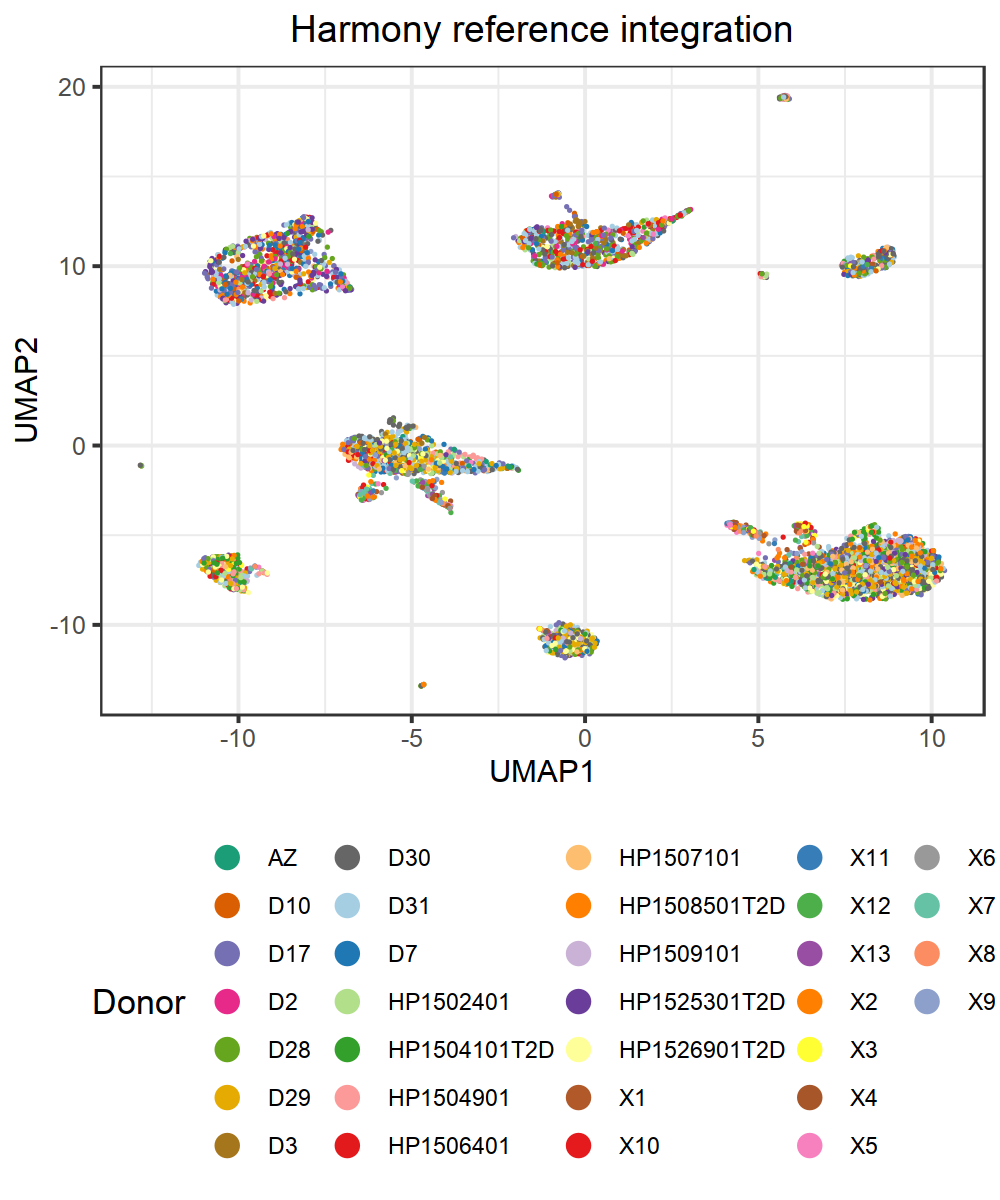

In [6]:
# Plot UMAP visualization
fig.size(6, 5)
library(RColorBrewer)
mycolors = c(brewer.pal(name="Dark2", n = 8), brewer.pal(name="Paired", n = 12),
            brewer.pal(name="Set1", n = 9), brewer.pal(name="Set2", n = 8),
            brewer.pal(name='Accent', n = 7), brewer.pal(name='Set3', n = 12))

p = all_meta %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = donor)) +
    geom_point(size = 0.6, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Harmony reference integration', color = 'Donor') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    scale_color_manual(values = mycolors) +
    theme(legend.position="bottom") +
    theme(legend.text = element_text(size=8), legend.title=element_text(size=12)) + 
    guides(colour = guide_legend(override.aes = list(size = 4)))
p

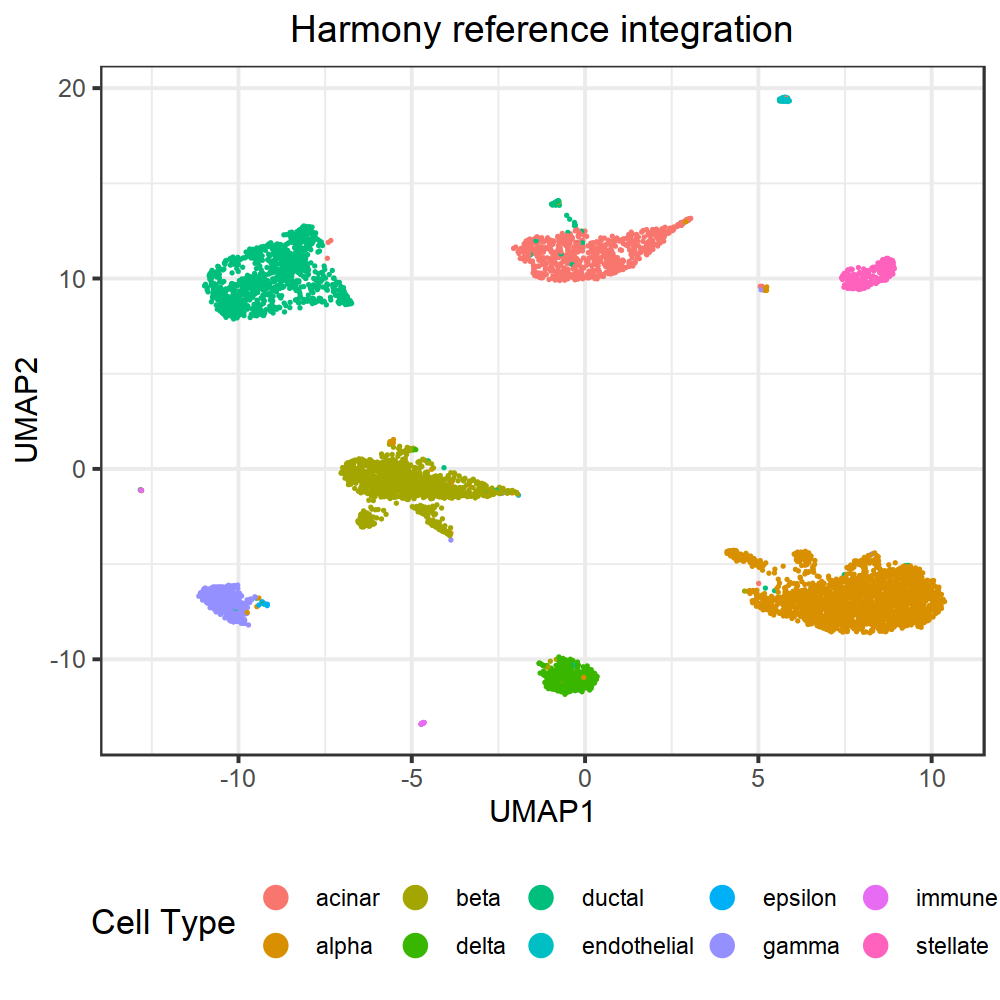

In [7]:
# Plot UMAP visualization
fig.size(5, 5)
library(RColorBrewer)
mycolors = c(brewer.pal(name="Dark2", n = 8), brewer.pal(name="Paired", n = 12),
            brewer.pal(name="Set1", n = 9), brewer.pal(name="Set2", n = 8),
            brewer.pal(name='Accent', n = 7), brewer.pal(name='Set3', n = 12))

all_meta$cell_type = droplevels(as.factor(all_meta$cell_type))
p = all_meta %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_type)) +
    geom_point(size = 0.6, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Harmony reference integration', color = 'Cell Type') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    #scale_color_manual(values = celltype.colors) +
    theme(legend.position="bottom") +
    theme(legend.text = element_text(size=8), legend.title=element_text(size=12)) + 
    guides(colour = guide_legend(override.aes = list(size = 4)))
p

In [8]:
table(reference$meta_data$cell_type)


                 acinar       alpha        beta       delta      ductal 
          0         702        2081        1106         360        1008 
endothelial     epsilon       gamma      immune    stellate 
         52           7         333          27         211 

## Save to pre-built references

In [10]:
# Save UMAP model
save_uwot_path = '/data/srlab2/jkang/symphony_reproducibility/pre-built_references/pancreas_plate-based_uwot_model'
model = uwot::save_uwot(umap, file = save_uwot_path, unload = FALSE, verbose = FALSE)
save_uwot_path = '../pre-built_references/pancreas_plate-based_uwot_model'
reference$save_uwot_path = save_uwot_path

# Save UMAP coordinates
colnames(umap$embedding) = c('UMAP1', 'UMAP2')
reference$umap = umap

Warning message:
“invalid uid value replaced by that for user 'nobody'”


In [12]:
saveRDS(reference, '../../pre-built_references/pancreas_plate-based_reference.rds')

## "Humanize" the query mouse expression matrix

In [4]:
mouse = readRDS('/data/srlab/jkang/referencemapping/pancreas/data/baron-mouse.rds')
mouse_exp = Matrix(mouse@assays$data@listData$counts, sparse = TRUE)
mouse_exp = as(mouse_exp, "dgCMatrix")

In [5]:
combined_map_nodup = readRDS('../../data/Fig4_pancreas_multi/ensembl_homologene_human-to-mouse_mapping.rds')
# This file was created in 2021-01-11_debug_mouse.ipynb
dim(combined_map_nodup)

[1] 22578     2

In [6]:
humanized_mouse_exp = map_species(mouse_exp, rownames(human_exp_norm), from='mouse', to='human', 
                                    orthologs_table = combined_map_nodup, round_fxn=identity)
dim(humanized_mouse_exp)

CAUTION: orthologs_table should have columns MGI.symbol and HGNC.symbol



[1] 20873  1886

In [7]:
human_metadata = readRDS('../../data/Fig4_pancreas_multi/baron_human_metadata.rds')
mouse_metadata = readRDS('../../data/Fig4_pancreas_multi/baron_mouse_metadata.rds')

human_metadata$species_donor = paste0(human_metadata$species, human_metadata$donor)
mouse_metadata$species_donor = paste0(mouse_metadata$species, mouse_metadata$donor)

saveRDS(human_metadata, '../../data/Fig4_pancreas_multi/baron_human_metadata.rds')
saveRDS(mouse_metadata, '../../data/Fig4_pancreas_multi/baron_mouse_metadata.rds')

In [8]:
## Normalization after ortholog mapping
mouse_exp_norm = singlecellmethods::normalizeData(humanized_mouse_exp, 1e4, 'log')

In [9]:
## Save the humanized mouse exprs
saveRDS(mouse_exp_norm, '../../data/Fig4_pancreas_multi/baron_mouse_biomart_homologene_exp.rds')

## Map query mouse and human simultaneously

In [10]:
reference = readRDS('Symphony_reference_four.rds')
human_exp_norm = readRDS('../../data/Fig4_pancreas_multi/baron_human_exp.rds')

In [11]:
## To map the human and mouse simultaneously, combine the two sparse matrices
combined_filled <- t(plyr::rbind.fill.matrix(t(mouse_exp_norm), t(human_exp_norm)))
combined_filled[is.na(combined_filled)] = 0 # fill in any missing genes with 0
colnames(combined_filled) = c(rownames(mouse_metadata), rownames(human_metadata))

In [12]:
dim(combined_filled)
combined_filled[1:5, 1:5]

[1] 26000 10455

,mouse1_lib1.final_cell_0001,mouse1_lib1.final_cell_0002,mouse1_lib1.final_cell_0003,mouse1_lib1.final_cell_0004,mouse1_lib1.final_cell_0005
13CDNA73,0,0,0,0,0
15E1.2,0,0,0,0,0
182-FIP,0,0,0,0,0
3'HEXO,0,0,0,0,0
384D8-2,0,0,0,0,0


In [13]:
## Mapping
system.time({
query_combined = mapQuery(exp_query = combined_filled, 
                          metadata_query = rbind(mouse_metadata, human_metadata),
                          ref_obj = reference,
                          vars = c('dataset', 'species', 'species_donor'), 
                          do_normalize = FALSE)
})

Scaling and synchronizing query gene expression

Found 2236 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

All done!



   user  system elapsed 
  3.060   3.753   1.568 

In [14]:
saveRDS(query_combined, 'query_baron.rds')

In [15]:
## Combine ref and query into one embedding
mappingZ = rbind(t(query_combined$Z), t(reference$Z_corr))
rownames(mappingZ) = c(as.character(rownames(query_combined$meta_data)), 
                       as.character(reference$meta_data$cell_id))
mapping_meta = readRDS('../../data/Fig4_pancreas_multi/all_meta.rds')

## Match cell order
mappingZ = mappingZ[order(match(rownames(mappingZ), rownames(mapping_meta))), ]

## Save mapping embedding
dim(mappingZ)
saveRDS(mappingZ, 'Symphony_mapping_embedding.rds')

[1] 16342    20

In [16]:
message('Run de novo UMAP on mapping of cells')
set.seed(0)
umap = uwot::umap(mappingZ, n_neighbors = 30, learning_rate = 0.5, init = "laplacian", 
        metric = 'cosine', fast_sgd = FALSE, n_sgd_threads = 1,
        min_dist = .3, n_threads = 4, ret_model = TRUE)
colnames(umap$embedding) = c('UMAP1', 'UMAP2')
all_meta = cbind(mapping_meta, umap$embedding)

Run de novo UMAP on mapping of cells



null device 
          1

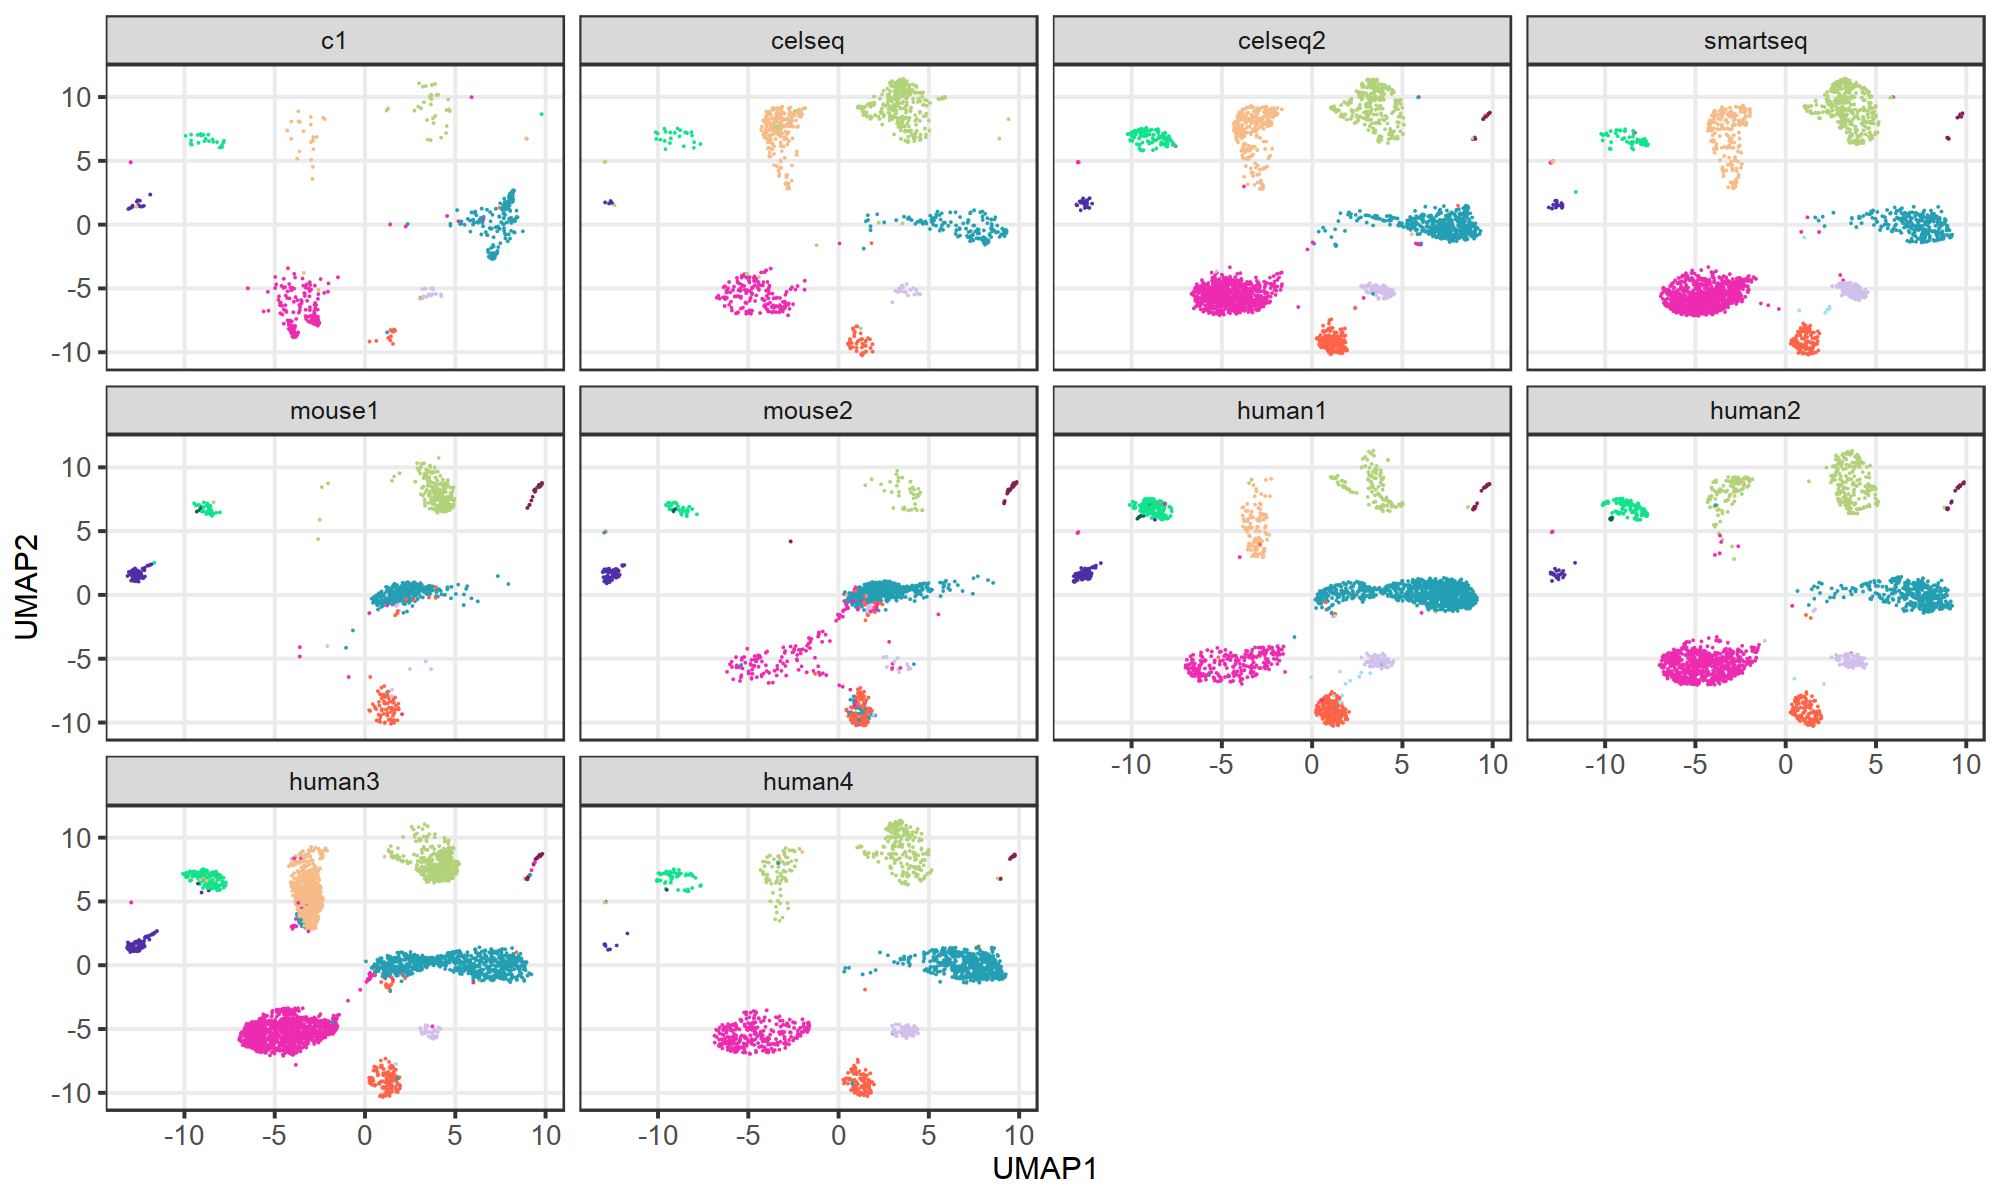

In [17]:
fig.size(6, 10)
p = all_meta %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) +
    geom_point_rast(aes(color = cell_type), size = 0.2, shape = 16) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5)) + 
    scale_color_manual(values = celltype.colors) +
    theme(legend.position="none") +
    theme(axis.text=element_text(size=10)) + xlab('UMAP1') + ylab('UMAP2') +
    theme(legend.text = element_text(size=14), plot.title = element_text(size=16), 
          legend.title=element_text(size=14)) + 
    guides(colour = guide_legend(override.aes = list(size = 4))) +
    scale_x_continuous(minor_breaks = seq(-10, 10, 5)) +
    scale_y_continuous(minor_breaks = seq(-10, 10, 5)) + facet_wrap(~batch)
print(p)
dev.off()
p

# De novo Harmony integration

In [37]:
## Read in metadata that applies to all cells
metadata = readRDS('../../data/Fig4_pancreas_multi/all_meta.rds')

In [38]:
## Read in query exprs
human_exp = readRDS('../../data/Fig4_pancreas_multi/baron_human_exp.rds')
human_metadata = readRDS('../../data/Fig4_pancreas_multi/baron_human_metadata.rds')
mouse_exp = readRDS('../../data/Fig4_pancreas_multi/baron_mouse_biomart_homologene_exp.rds')
mouse_metadata = readRDS('../../data/Fig4_pancreas_multi/baron_mouse_metadata.rds')

In [40]:
# Combine the two sparse matrices
baron_filled = t(plyr::rbind.fill.matrix(t(mouse_exp), t(human_exp)))
colnames(baron_filled) = c(colnames(mouse_exp), colnames(human_exp))
baron_filled[is.na(baron_filled)] = 0 # fill in missing genes with 0
dim(baron_filled)

[1] 26000 10455

In [41]:
ref_exprs_norm = readRDS('../../data/Fig4_pancreas_multi/reference_four_exp.rds')
dim(ref_exprs_norm)

[1] 15369  5887

In [42]:
all_filled = t(plyr::rbind.fill.matrix(t(ref_exprs_norm), t(baron_filled)))
colnames(all_filled) = c(colnames(ref_exprs_norm), colnames(baron_filled))

In [43]:
## match the cells order with metadata
all_filled = all_filled[order(match(rownames(all_filled), rownames(metadata))), ]
all_filled[is.na(all_filled)] = 0 # fill in missing genes with 0
all_filled = Matrix(all_filled, sparse = TRUE)

In [44]:
saveRDS(all_filled, '../../data/Fig4_pancreas_multi/combined_exprs_norm_new_mouse.rds')

### Run Harmony

Using top 1000 per dataset performs better than top 1000 per batch

In [46]:
system.time({

message('Variable gene selection')
# Select and subset expression by variable genes
var_genes = vargenes_vst(all_filled, groups = as.character(metadata$dataset), topn = 1000)
exprs_norm_vargenes = all_filled[var_genes, ]
message(paste0('Using ', nrow(exprs_norm_vargenes), ' vargenes'))

# Calculate and save the mean and standard deviations for each gene
vargenes_means_sds = tibble(symbol = var_genes, mean = Matrix::rowMeans(exprs_norm_vargenes))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(exprs_norm_vargenes, vargenes_means_sds$mean)

## Scale data
exp_scaled = singlecellmethods::scaleDataWithStats(exprs_norm_vargenes, vargenes_means_sds$mean, 
                                                        vargenes_means_sds$stddev, 1)
## Run SVD, save gene loadings (s$u)
s = irlba(exp_scaled, nv = 20)
Z_pca = diag(s$d) %*% t(s$v) # [pcs by cells]
loadings = s$u
    
message('Harmonize')
# Run Harmony
set.seed(0)
harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca), ## PCA embedding matrix of cells
        meta_data = metadata, ## dataframe with cell labels
        theta = c(2, 2, 2), ## cluster diversity enforcement
        vars_use = c('species', 'donor', 'dataset'), ## variable to integrate out
        nclust = 100, ## number of clusters in Harmony model
        max.iter.harmony = 10,
        tau = 5,
        return_object = TRUE, ## return the full Harmony model object
        do_pca = FALSE ## don't recompute PCs
)
})

denovo = symphony::buildReferenceFromHarmonyObj(
                           harmObj,            # output object from HarmonyMatrix()
                           metadata,
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs
                           verbose = TRUE,
                           do_umap = FALSE)

Variable gene selection

Using 2650 vargenes

Harmonize

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony converged after 8 iterations



   user  system elapsed 
223.793 492.317  38.333 

Save metadata, vargenes (S), and loadings (U)

Save R, Z_orig, Z_corr, and betas from Harmony object

Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

Finished nicely.



In [52]:
## Save variable genes used
write.csv(denovo$vargenes, '../../data/Fig4_pancreas_multi/denovo_top1000perdataset_total2650_vargenes.csv')

## Save object
saveRDS(denovo, 'denovo_obj.rds')

In [53]:
message('Run de novo UMAP on de novo integrated cells')
set.seed(0)
umap <- uwot::umap( t(denovo$Z_corr), n_neighbors = 30, learning_rate = 0.5, init = "laplacian", 
        metric = 'cosine', fast_sgd = FALSE, n_sgd_threads = 1,
        min_dist = .3, n_threads = 4, ret_model = TRUE)
colnames(umap$embedding) = c('UMAP1', 'UMAP2')
all_meta = cbind(metadata, umap$embedding)

Run de novo UMAP on de novo integrated cells



In [54]:
# Add centroid locations
centroids = denovo$Z_corr %*% t(denovo$R)
umap_centroids = uwot::umap_transform(t(centroids), umap)
umap_centroids= umap_centroids %>% as.data.frame()
colnames(umap_centroids) = c('UMAP1', 'UMAP2')

Plot the de novo integration



null device 
          1

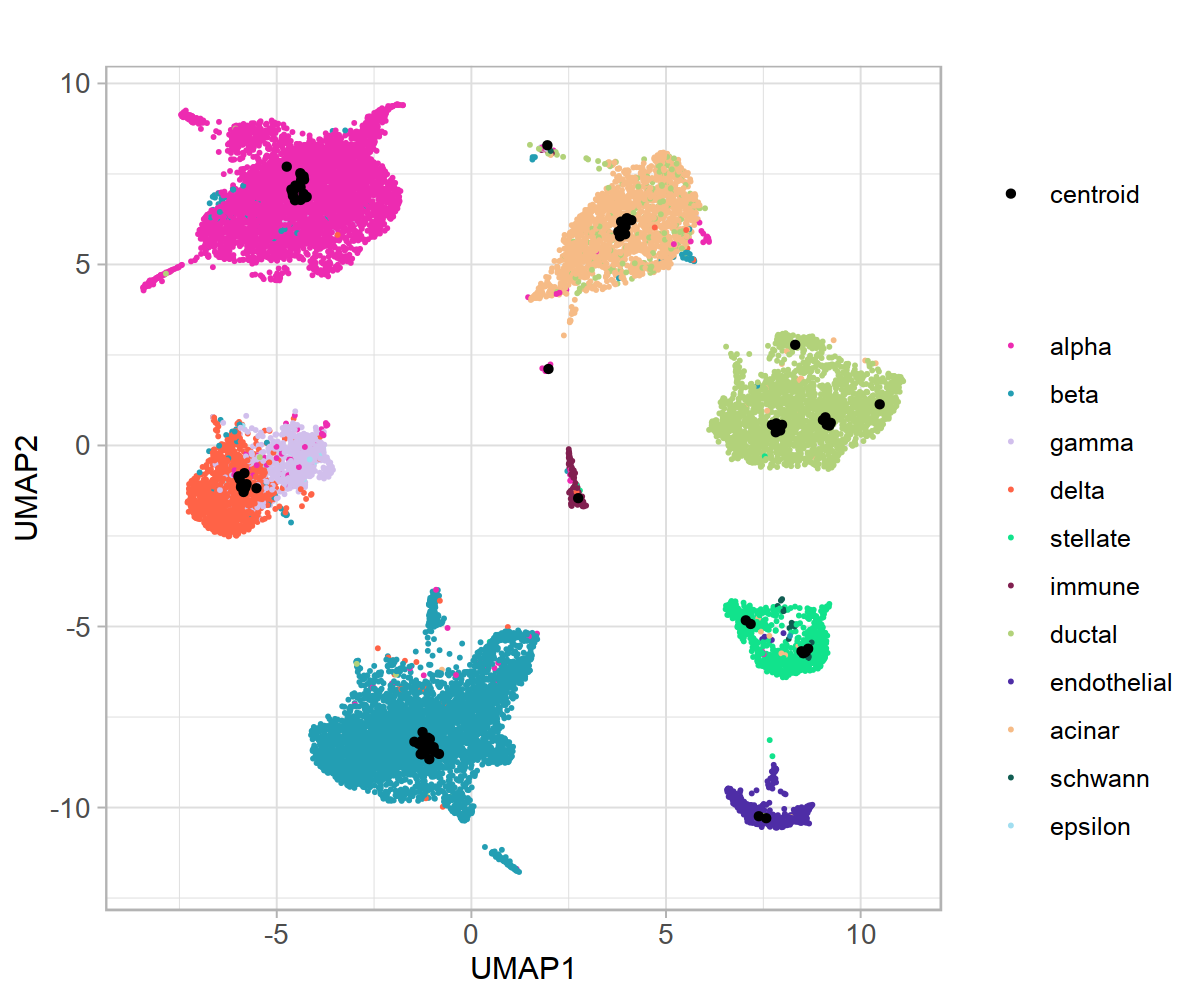

In [55]:
## Plot de novo integration
message('Plot the de novo integration')
fig.size(5, 6)

p = all_meta %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2)) +
    geom_point(aes(color = cell_type), size = 0.5, shape = 16) +
    geom_point(data = umap_centroids, aes(x = UMAP1, y = UMAP2, fill = 'centroid'), size = 0.8) +
    theme_light() +
    labs(title = '', color = '', fill = '') + 
    theme(plot.title = element_text(hjust = 0.5)) + 
    scale_color_manual(values = celltype.colors) +
    theme(legend.position="right") +
    theme(axis.text=element_text(size=10)) + xlab('UMAP1') + ylab('UMAP2')
print(p)
dev.off()

In [56]:
## Match cell order
colnames(denovo$Z_corr) = rownames(denovo$meta_data)
denovoZ = t(denovo$Z_corr)[order(match(rownames(t(denovo$Z_corr)), rownames(metadata))), ]

## Save mapping embedding
dim(denovoZ)
saveRDS(denovoZ, 'denovo_embedding.rds')

[1] 16342    20

In [57]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggthemes_4.2.4          patchwork_1.1.1         ggrepel_0.9.1          
 [4] ggpubr_0.4.0            ggrastr_0.2.3           RColorBrewer_1.1-2     
 [7] pheatmap_1.0.12         biomaRt_2.46.3          symphony_1.0           
[10] SeuratObject_4.0.1      Seurat